# Set up environment

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import os
import PIL.Image as Image
import time
import numpy as np
import matplotlib.pyplot as plt
import requests
from torchsummary import summary

## Declare parameters

In [22]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))

IMAGE_SIZE = 299
BATCH_SIZE = 16

## Enable GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


# Input model

## Declare model architecture

Currently supports:
    - inception_v3
    - mobilenet_v2
    - wide_resnet_101

In [61]:
MODEL_NAME = "wide_resnet_101"

## Fetch model architecture

In [62]:
print("Fetching model... ", end="")

# fetch feature extractor
if MODEL_NAME == "inception_v3":
    model = torchvision.models.inception_v3(pretrained=True)
elif MODEL_NAME == "mobilenet_v2":
    model = torchvision.models.mobilenet_v2(pretrained=False)
elif MODEL_NAME == "wide_resnet_101":
    model = torchvision.models.wide_resnet101_2(pretrained=False)
    
# freeze feature extractor
for param in model.parameters():
    param.requires_grad = False

# replace classification head
if MODEL_NAME == "inception_v3":
    # handle auxilary net
    num_features = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = torch.nn.Linear(num_features, 101)

    # handle primary net
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, 101)
    
elif MODEL_NAME == "mobilenet_v2":
    num_features = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_features, 101)
    
elif MODEL_NAME == "wide_resnet_101":
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, 101)

model = model.to(device)
print("done")

Fetching model... done


## Load model weights

In [63]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "food_classification", MODEL_NAME, "fine_tuning.pt")

print("Loading learnt model weights...", end="")
model.load_state_dict(torch.load(MODEL_PATH))
print("done")

Loading learnt model weights...done


## Show model summary

In [64]:
summary(model, (3, IMAGE_SIZE, IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5          [-1, 128, 75, 75]           8,192
       BatchNorm2d-6          [-1, 128, 75, 75]             256
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,456
       BatchNorm2d-9          [-1, 128, 75, 75]             256
             ReLU-10          [-1, 128, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]          32,768
      BatchNorm2d-12          [-1, 256, 75, 75]             512
           Conv2d-13          [-1, 256, 75, 75]          16,384
      BatchNorm2d-14          [-1, 256,

# Evaluate model on testing dataset

## Fetch test dataset

In [65]:
FOOD101_DIR = os.path.join(os.path.abspath(os.sep), "Datasets", "food101")
TEST_DIR = os.path.join(FOOD101_DIR, "test")

test_transform = transforms.Compose([
  transforms.Resize(IMAGE_SIZE),
  transforms.CenterCrop(IMAGE_SIZE),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_raw = torchvision.datasets.ImageFolder(TEST_DIR, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_raw, batch_size=BATCH_SIZE)
test_size = len(test_raw)

class_names = test_raw.classes

## Define testing loop

In [66]:
def test():
  model.eval()
  top1_corrects = 0
  top5_corrects = 0

  for (images, labels) in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # fit images on model
    with torch.no_grad():
      outputs = model(images)
    
      # fetch top 5 results
      _, predictions = outputs.topk(5, 1, True, True)
      predictions = predictions.t()
      correct = predictions.eq(labels.data.view(1, -1).expand_as(predictions))
    
    top1_corrects += correct[:1].sum()
    top5_corrects += correct.sum()
    
  # calculate statistics
  top1 = top1_corrects.double() / test_size
  top5 = top5_corrects.double() / test_size

  return top1, top5

## Run testing

In [51]:
top1, top5 = test()

print("Top-1 accuracy: {0}\nTop-5 accuracy {1}".format(top1, top5))

Top-1 accuracy: 0.1525940594059406
Top-5 accuracy 0.327960396039604


# Show inference on batch of test images

In [67]:
def predict(images):
    images = images.to(device)
    model.eval()
    
    with torch.no_grad():
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
    
    return [class_names[i] for i in predictions]

# randomly select 20 images from validation set
images = []
real_classes = []
for i in range(20):
    j = np.random.randint(test_size)
    img, lbl = test_raw[j]
    images.append(img.numpy())
    real_classes.append(class_names[lbl])

inputs = torch.tensor(images)
predicted_classes = predict(inputs)

## Show estimated classes against real

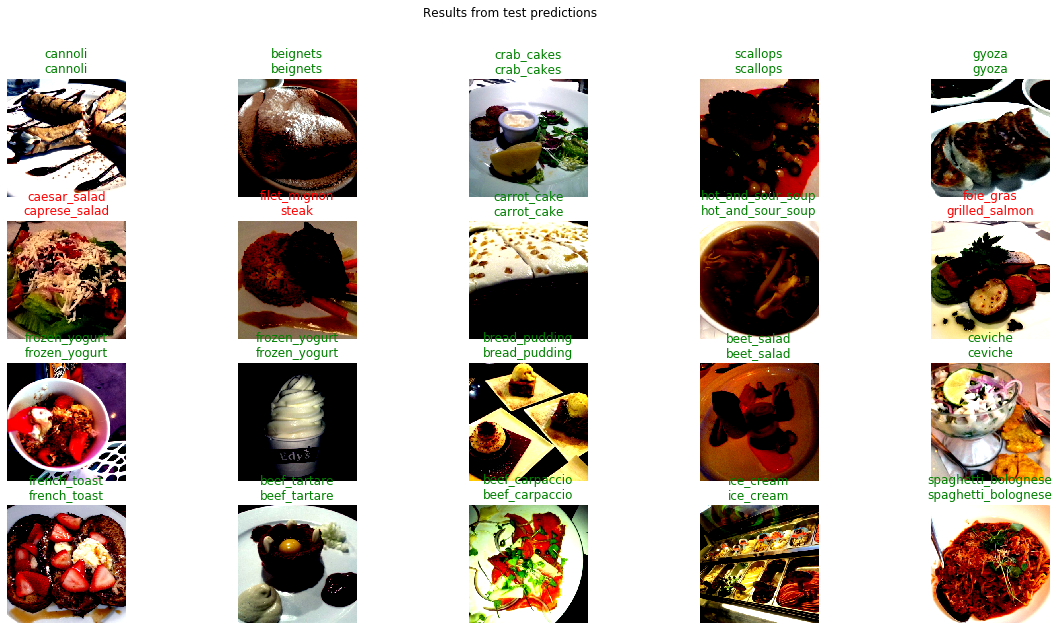

In [73]:
cols, rows = 5, 4
fig = plt.figure(figsize=(20,10))
fig.suptitle("Results from test predictions")

for i in range(1, cols*rows+1):
  fig.add_subplot(rows, cols, i)

  # randomly sellect image from dataset
  img = images[i-1]
  img = np.transpose(img, (1,2,0))
  img = img * (0.485, 0.456, 0.406) + (0.229, 0.224, 0.225)

  # display title as green if correct otherwise red
  color = "green" if predicted_classes[i-1] == real_classes[i-1] else "red"
  plt.title(predicted_classes[i-1]+'\n'+real_classes[i-1], color=color)
  plt.axis("off")
  img = np.clip(img, 0, 1)
  plt.imshow(img, interpolation="nearest")
plt.show()

# Measaure inference time

In [70]:
# create random noise as input
x = torch.rand([1, 3, IMAGE_SIZE, IMAGE_SIZE])
x = x.to(device)

# measure inference
start = time.time()
model.eval()
    
with torch.no_grad():
    _ = model(x)

ellapsed = time.time() - start

print("Inference time: {0}".format(ellapsed))

Inference time: 0.025096654891967773
